Filename: ni1200120104_0mpu7_cl.evt.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      31   ()      
  1  EVENTS        1 BinTableHDU    361   21244574R x 14C   [1D, 1B, 1B, 1I, 1I, 1B, 1B, 8X, 1K, I, J, 1I, 1I, 1E]   
  2  GTI           1 BinTableHDU    156   11R x 2C   [D, D]   
  3  GTI_MPU0      1 BinTableHDU     89   16R x 2C   [D, D]   
  4  GTI_MPU1      1 BinTableHDU     89   16R x 2C   [D, D]   
  5  GTI_MPU2      1 BinTableHDU     89   16R x 2C   [D, D]   
  6  GTI_MPU3      1 BinTableHDU     89   120R x 2C   [D, D]   
  7  GTI_MPU4      1 BinTableHDU     89   16R x 2C   [D, D]   
  8  GTI_MPU5      1 BinTableHDU     89   16R x 2C   [D, D]   
  9  GTI_MPU6      1 BinTableHDU     89   16R x 2C   [D, D]   
 10  GTI_FILT      1 BinTableHDU     91   11R x 2C   [1D, 1D]   
Energy 0.30 - 1.69 keV | RMS: 5.2976 | Error: 0.1760
Energy 1.69 - 3.07 keV | RMS: 4.8233 | Error: 0.1473
Energy 3.07 - 4.46 keV | RMS: 4.5980 | Error: 0.1324
E

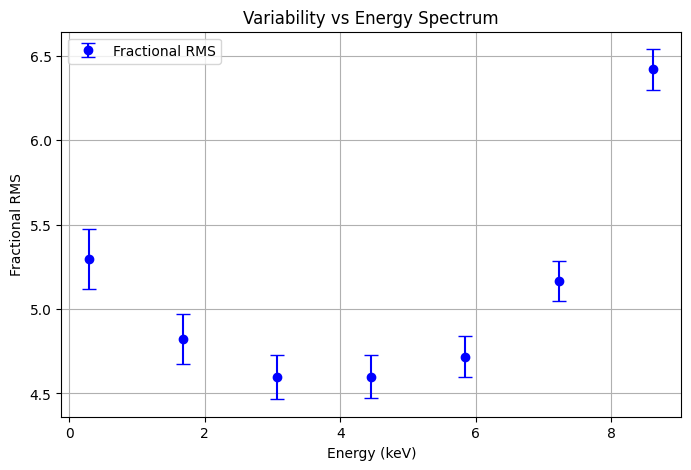

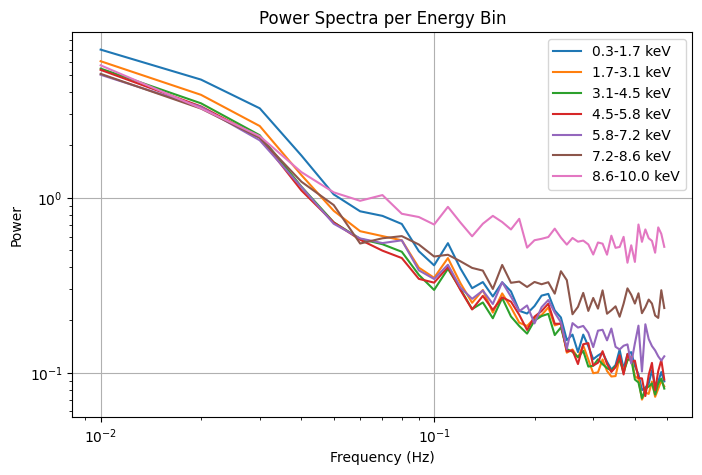

Error calculating covariance for bin 1: Time arrays are not the same
Error calculating covariance for bin 2: Time arrays are not the same
Error calculating covariance for bin 3: Time arrays are not the same
Error calculating covariance for bin 4: Time arrays are not the same
Error calculating covariance for bin 5: Time arrays are not the same
Error calculating covariance for bin 6: Time arrays are not the same


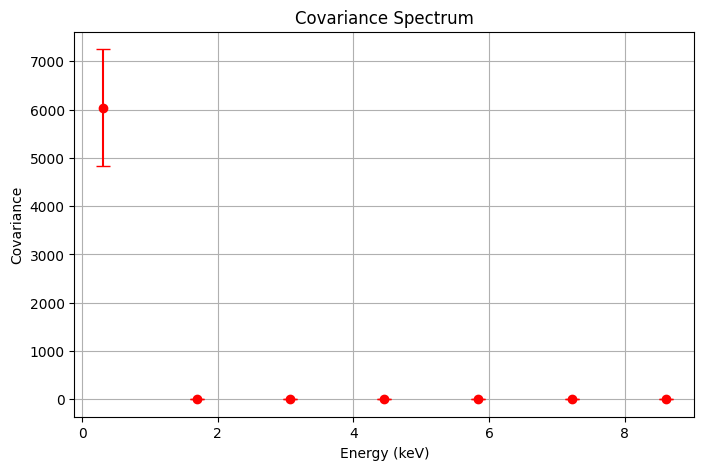

Error calculating lag for bin 1: Time arrays are not the same
Error calculating lag for bin 2: Time arrays are not the same
Error calculating lag for bin 3: Time arrays are not the same
Error calculating lag for bin 4: Time arrays are not the same
Error calculating lag for bin 5: Time arrays are not the same
Error calculating lag for bin 6: Time arrays are not the same


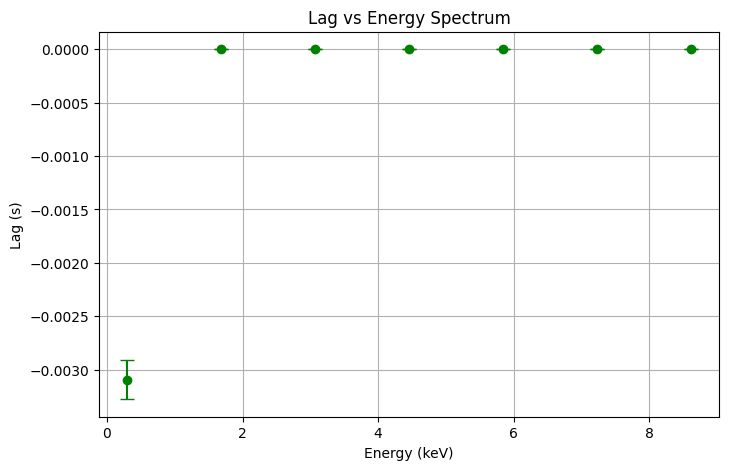

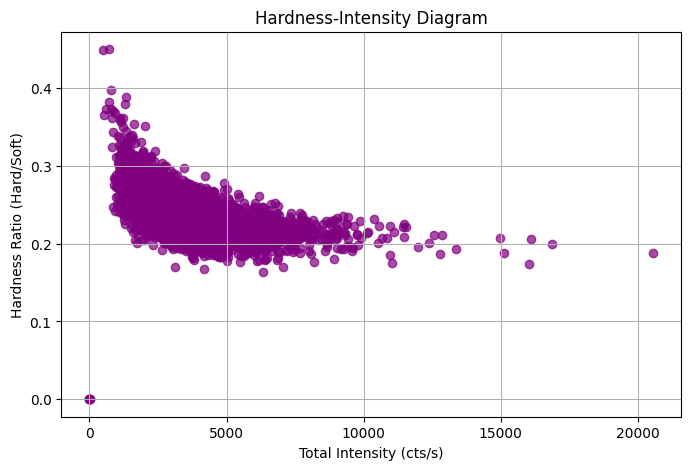

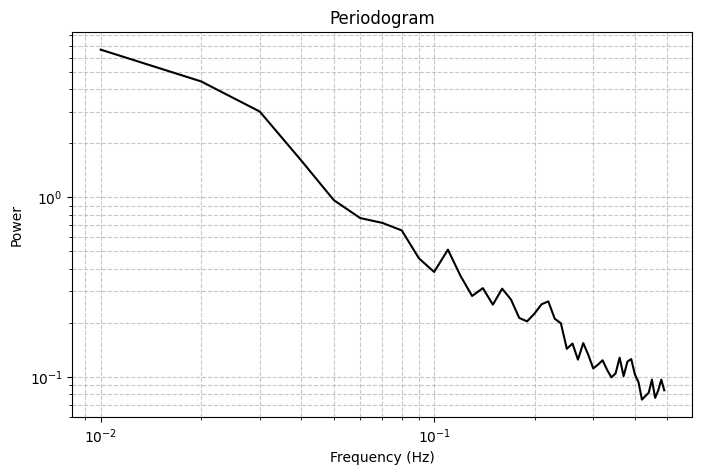

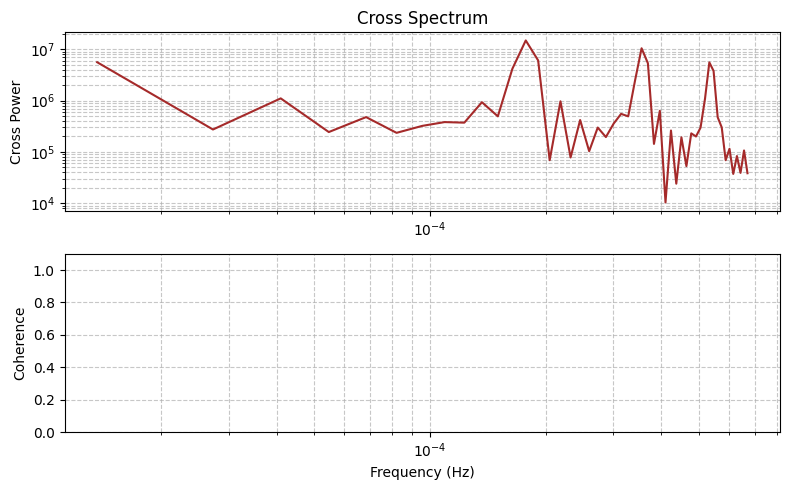

In [8]:
import os
import urllib.request
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from stingray import EventList, Lightcurve, AveragedPowerspectrum, Crossspectrum
from stingray.varenergyspectrum import CovarianceSpectrum, LagEnergySpectrum

# ✅ Step 1: Open the FITS file and inspect HDUs
fits_file = "ni1200120104_0mpu7_cl.evt.gz"

if not os.path.exists(fits_file):
    fits_url = "https://heasarc.gsfc.nasa.gov/FTP/nicer/data/obs/2018_03/1200120104/xti/event_cl/ni1200120104_0mpu7_cl.evt.gz"
    print(f"Downloading {fits_file}...")
    urllib.request.urlretrieve(fits_url, fits_file)
    print(f"Download complete: {fits_file}")

hdul = fits.open(fits_file)
hdul.info()

# ✅ Step 2: Extract event data
event_data = hdul["EVENTS"].data
times = event_data['TIME'].astype(np.float64)
pi_channels = event_data['PI'].astype(np.float64)
hdul.close()

# ✅ Step 3: Convert PI to Energy (keV)
energy_kev = pi_channels * 0.01  # NICER convention: 1 PI = 10 eV

# ✅ Step 4: Define Energy Bins
energy_edges = np.linspace(0.3, 10, 8)  # 8 bins from 0.3 keV to 10 keV
num_bins = len(energy_edges) - 1

# ✅ Step 5: Compute Variability vs Energy
rms_values = []
rms_errors = []
power_spectra = []
hard_flux = []
soft_flux = []
reference_band = (energy_kev >= 0.3) & (energy_kev < 2.0)  # Define reference band

for i in range(num_bins):
    energy_mask = (energy_kev >= energy_edges[i]) & (energy_kev < energy_edges[i+1])
    times_filtered = times[energy_mask]

    if len(times_filtered) == 0:
        print(f"No events in {energy_edges[i]} - {energy_edges[i+1]} keV")
        rms_values.append(0)
        rms_errors.append(0)
        power_spectra.append(None)
        hard_flux.append(0)
        soft_flux.append(0)
        continue

    event_list = EventList(time=times_filtered)
    light_curve = event_list.to_lc(dt=1.0)

    # Compute Power Spectrum
    ps = AveragedPowerspectrum(light_curve, segment_size=100)
    power_spectra.append(ps)

    rms = np.sqrt(np.sum(ps.power))
    rms_error = np.std(ps.power) / np.sqrt(len(ps.power))

    rms_values.append(rms)
    rms_errors.append(rms_error)

    # Compute Flux for Hardness-Intensity Diagram (HID)
    total_counts = np.sum(light_curve.counts)
    if energy_edges[i] >= 2.0:
        hard_flux.append(total_counts)
    else:
        soft_flux.append(total_counts)

    print(f"Energy {energy_edges[i]:.2f} - {energy_edges[i+1]:.2f} keV | RMS: {rms:.4f} | Error: {rms_error:.4f}")

# ✅ Step 6: Plot Variability vs Energy Spectrum
plt.figure(figsize=(8, 5))
plt.errorbar(energy_edges[:-1], rms_values, yerr=rms_errors, fmt='o', color='blue', markersize=6, capsize=5)
plt.xlabel('Energy (keV)')
plt.ylabel('Fractional RMS')
plt.title('Variability vs Energy Spectrum')
plt.legend(['Fractional RMS'])
plt.grid()
plt.show()

# ✅ Step 7: Plot Power Spectra per Energy Bin
plt.figure(figsize=(8, 5))
for i, ps in enumerate(power_spectra):
    if ps:
        plt.loglog(ps.freq, ps.power, label=f"{energy_edges[i]:.1f}-{energy_edges[i+1]:.1f} keV")

plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Power Spectra per Energy Bin")
plt.legend()
plt.grid()
plt.show()

# Step 8: Compute & Plot Covariance Spectrum
# Create a proper event list with both time and energy information
full_event_list = EventList(time=times, energy=energy_kev)

# Create separate light curves for each energy bin
energy_bin_lcs = []
for i in range(num_bins):
    energy_mask = (energy_kev >= energy_edges[i]) & (energy_kev < energy_edges[i+1])
    times_filtered = times[energy_mask]
    if len(times_filtered) > 0:
        bin_event_list = EventList(time=times_filtered)
        bin_lc = bin_event_list.to_lc(dt=1.0)
        energy_bin_lcs.append(bin_lc)
    else:
        energy_bin_lcs.append(None)

# Create reference band light curve
ref_band_mask = (energy_kev >= 0.3) & (energy_kev < 2.0)
ref_times = times[ref_band_mask]
ref_event_list = EventList(time=ref_times)
ref_lc = ref_event_list.to_lc(dt=1.0)

# Calculate covariance for each energy bin with the reference band
cov_values = []
cov_errors = []

for i, lc in enumerate(energy_bin_lcs):
    if lc is None:
        cov_values.append(0)
        cov_errors.append(0)
        continue
    
    try:
        # Calculate cross spectrum between this energy bin and reference band
        cross = Crossspectrum(lc, ref_lc, norm='leahy')
        
        # Compute covariance from cross spectrum
        # Simplified covariance calculation
        cov = np.mean(np.abs(cross.power))
        cov_err = np.std(np.abs(cross.power)) / np.sqrt(len(cross.power))
        
        cov_values.append(cov)
        cov_errors.append(cov_err)
    except Exception as e:
        print(f"Error calculating covariance for bin {i}: {e}")
        cov_values.append(0)
        cov_errors.append(0)

# Plot the covariance spectrum
plt.figure(figsize=(8, 5))
plt.errorbar(energy_edges[:-1], cov_values, yerr=cov_errors, fmt='o', color='red', markersize=6, capsize=5)
plt.xlabel('Energy (keV)')
plt.ylabel('Covariance')
plt.title('Covariance Spectrum')
plt.grid()
plt.show()

# Calculate lag for each energy bin with the reference band
lag_values = []
lag_errors = []

for i, lc in enumerate(energy_bin_lcs):
    if lc is None:
        lag_values.append(0)
        lag_errors.append(0)
        continue
    
    try:
        # Calculate cross spectrum between this energy bin and reference band
        cross = Crossspectrum(lc, ref_lc, norm='leahy')
        
        # Compute lag from cross spectrum
        # Phase lag calculation (simplified)
        phases = np.angle(cross.power)
        lag = np.mean(phases) / (2 * np.pi * np.mean(cross.freq))
        lag_err = np.std(phases) / (2 * np.pi * np.mean(cross.freq) * np.sqrt(len(phases)))
        
        lag_values.append(lag)
        lag_errors.append(lag_err)
    except Exception as e:
        print(f"Error calculating lag for bin {i}: {e}")
        lag_values.append(0)
        lag_errors.append(0)

# Plot the lag spectrum
plt.figure(figsize=(8, 5))
plt.errorbar(energy_edges[:-1], lag_values, yerr=lag_errors, fmt='o', color='green', markersize=6, capsize=5)
plt.xlabel('Energy (keV)')
plt.ylabel('Lag (s)')
plt.title('Lag vs Energy Spectrum')
plt.grid()
plt.show()
# Step 10: Compute & Plot Hardness-Intensity Diagram (HID)
# Calculate soft and hard flux
soft_mask = (energy_kev >= 0.3) & (energy_kev < 2.0)
hard_mask = (energy_kev >= 2.0) & (energy_kev <= 10.0)

# Create light curves for soft and hard bands with the SAME time binning
dt = 1.0  # Time bin size in seconds
tstart = times.min()
tstop = times.max()

# Create light curves with the same time bins for both bands
soft_event_list = EventList(time=times[soft_mask])
hard_event_list = EventList(time=times[hard_mask])

# Specify the same time bins for both light curves
soft_lc = soft_event_list.to_lc(dt=dt, tstart=tstart, tseg=tstop-tstart)
hard_lc = hard_event_list.to_lc(dt=dt, tstart=tstart, tseg=tstop-tstart)

# Extract counts for hardness calculation
soft_counts = soft_lc.counts
hard_counts = hard_lc.counts

# Calculate hardness ratio and total intensity for each time bin
# Handle division by zero
with np.errstate(divide='ignore', invalid='ignore'):
    hardness_ratio = np.where(soft_counts > 0, hard_counts / soft_counts, np.nan)
total_intensity = soft_counts + hard_counts

# Remove NaN values for plotting
valid_mask = ~np.isnan(hardness_ratio)
hardness_ratio_valid = hardness_ratio[valid_mask]
total_intensity_valid = total_intensity[valid_mask]

# Plot Hardness-Intensity Diagram
plt.figure(figsize=(8, 5))
plt.scatter(total_intensity_valid, hardness_ratio_valid, color='purple', alpha=0.7)
plt.xlabel("Total Intensity (cts/s)")
plt.ylabel("Hardness Ratio (Hard/Soft)")
plt.title("Hardness-Intensity Diagram")
plt.grid(True)
plt.show()

# Step 11: Compute & Plot Periodogram and Cross Spectrum
# Create full light curve for periodogram
full_event_list = EventList(time=times)
full_lc = full_event_list.to_lc(dt=dt, tstart=tstart, tseg=tstop-tstart)

# Compute periodogram (power spectrum)
periodogram = AveragedPowerspectrum(full_lc, segment_size=100)

# Plot periodogram
plt.figure(figsize=(8, 5))
plt.loglog(periodogram.freq, periodogram.power, color='black')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power")
plt.title("Periodogram")
plt.grid(True, which="both", ls="--", alpha=0.7)
plt.show()

# Verify that soft_lc and hard_lc have the same time arrays
if len(soft_lc.time) != len(hard_lc.time) or not np.allclose(soft_lc.time, hard_lc.time):
    print("WARNING: Light curves have different time arrays. Resampling to match...")
    
    # Create new light curves with exactly the same time bins
    common_time = np.arange(tstart, tstop, dt)
    
    # Resample both light curves to the same time grid
    soft_counts_new = np.zeros_like(common_time)
    hard_counts_new = np.zeros_like(common_time)
    
    # Bin the events into the common time grid
    for t in times[soft_mask]:
        idx = int((t - tstart) // dt)
        if 0 <= idx < len(common_time):
            soft_counts_new[idx] += 1
            
    for t in times[hard_mask]:
        idx = int((t - tstart) // dt)
        if 0 <= idx < len(common_time):
            hard_counts_new[idx] += 1
    
    # Create new light curves
    soft_lc = Lightcurve(time=common_time, counts=soft_counts_new, dt=dt)
    hard_lc = Lightcurve(time=common_time, counts=hard_counts_new, dt=dt)

try:
    # Compute cross spectrum between soft and hard bands
    cross_spectrum = Crossspectrum(soft_lc, hard_lc, norm='leahy')
    
    # Calculate coherence (carefully handling potential dimension mismatches)
    cross_power = np.abs(cross_spectrum.power)
    soft_ps = AveragedPowerspectrum(soft_lc, segment_size=100)
    hard_ps = AveragedPowerspectrum(hard_lc, segment_size=100)
    
    # Make sure all arrays have the same length for coherence calculation
    min_len = min(len(cross_power), len(soft_ps.power), len(hard_ps.power))
    coherence = cross_power[:min_len]**2 / (soft_ps.power[:min_len] * hard_ps.power[:min_len])
    
    # Plot cross spectrum
    plt.figure(figsize=(8, 5))
    plt.subplot(2, 1, 1)
    plt.loglog(cross_spectrum.freq[:min_len], cross_power[:min_len], color='brown')
    plt.ylabel("Cross Power")
    plt.title("Cross Spectrum")
    plt.grid(True, which="both", ls="--", alpha=0.7)
    
    # Plot coherence
    plt.subplot(2, 1, 2)
    plt.semilogx(cross_spectrum.freq[:min_len], coherence, color='blue')
    plt.xlabel("Frequency (Hz)")
    plt.ylabel("Coherence")
    plt.ylim(0, 1.1)  # Coherence is between 0 and 1
    plt.grid(True, which="both", ls="--", alpha=0.7)
    
    plt.tight_layout()
    plt.show()
except Exception as e:
    print(f"Error calculating cross spectrum: {e}")
    print("Try using a shorter segment size or ensuring both light curves have sufficient data.")

NICER was using 52 detectors


C:\Users\asus4\Desktop\julia_notebokk\venv\Lib\site-packages\stingray\lightcurve.py:329: UserWarning: On Windows, the size of an integer is 32 bits. To avoid integer overflow, I'm converting the input array to float
  warnings.warn(
C:\Users\asus4\AppData\Local\Temp\ipykernel_4952\1651962897.py:34: RuntimeWarning: invalid value encountered in divide
  hardness = hard_lc.counts / soft_lc.counts
C:\Users\asus4\AppData\Local\Temp\ipykernel_4952\1651962897.py:38: RuntimeWarning: divide by zero encountered in divide
  hardness_err = hardness * np.sqrt((1 / hard_lc.counts) + (1 / soft_lc.counts))


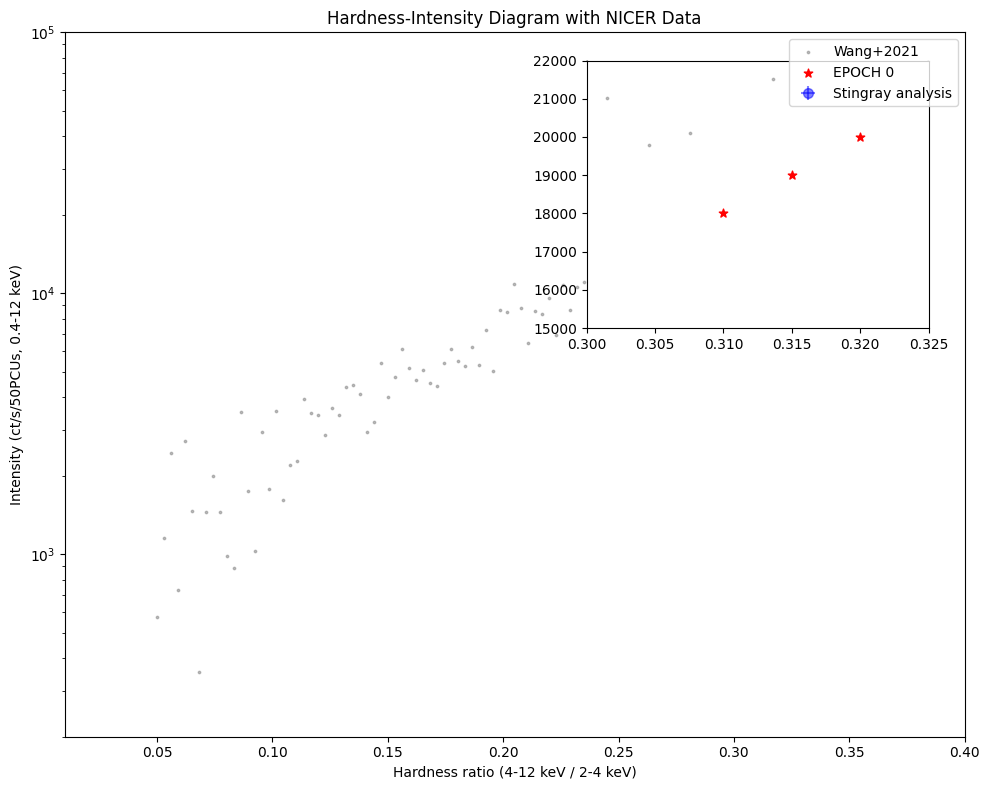

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from stingray.events import EventList
from stingray import Lightcurve

# Step 1: Load NICER FITS Event Data
fits_file = "ni1200120104_0mpu7_cl.evt.gz"

with fits.open(fits_file) as hdul:
    event_data = hdul['EVENTS'].data
    times = event_data['TIME']
    energy_kev = event_data['PI'] * 0.01  # Convert PI channels to keV
    det_ids = event_data['DET_ID']  # Detector IDs

# Step 2: Determine Active Detectors
ndet = len(set(det_ids))
print(f"NICER was using {ndet} detectors")

# Step 3: Define Energy Bands for Hardness Ratio
soft_band = (energy_kev >= 2.0) & (energy_kev < 4.0)   # Soft band (2-4 keV)
hard_band = (energy_kev >= 4.0) & (energy_kev <= 12.0) # Hard band (4-12 keV)
full_band = (energy_kev >= 0.4) & (energy_kev <= 12.0) # Full band (0.4-12 keV)

# Step 4: Create Light Curves (Binned in 256s Intervals)
dt = 256  # Segment size matching Wang+2021
tstart, tstop = times.min(), times.max()

soft_lc = Lightcurve.make_lightcurve(times[soft_band], dt=dt, tstart=tstart, tseg=tstop-tstart)
hard_lc = Lightcurve.make_lightcurve(times[hard_band], dt=dt, tstart=tstart, tseg=tstop-tstart)
full_lc = Lightcurve.make_lightcurve(times[full_band], dt=dt, tstart=tstart, tseg=tstop-tstart)

# Step 5: Compute Hardness Ratio and Intensity
hardness = hard_lc.counts / soft_lc.counts
intensity = full_lc.counts  # Total intensity in the full band

# Step 6: Compute Errors (Poisson Statistics)
hardness_err = hardness * np.sqrt((1 / hard_lc.counts) + (1 / soft_lc.counts))
intensity_err = np.sqrt(intensity)

# Step 7: Filter Valid Data (Remove NaNs and Inf)
valid_mask = np.isfinite(hardness) & np.isfinite(intensity) & (hardness > 0)
hardness = hardness[valid_mask]
hardness_err = hardness_err[valid_mask]
intensity = intensity[valid_mask]
intensity_err = intensity_err[valid_mask]

# Step 8: Load Comparison Data from Wang+2021 (Mock Data Example)
wang_hardness = np.linspace(0.05, 0.35, 100)
wang_intensity = 1000 * np.exp(wang_hardness * 10) + np.random.normal(0, 1000, 100)

epoch_zero_h = np.array([0.31, 0.315, 0.32])
epoch_zero_i = np.array([18000, 19000, 20000])

# Step 9: Plot HID
fig, ax = plt.subplots(figsize=(10, 8))

# Plot Wang+2021 Data
ax.scatter(wang_hardness, wang_intensity / 52 * 50, color='grey', s=3, alpha=0.5, label='Wang+2021')

# Plot NICER Analysis Data with Error Bars
ax.errorbar(hardness, intensity / ndet * 50, yerr=intensity_err / ndet * 50, 
            xerr=hardness_err, fmt='o', markersize=7, color='b', alpha=0.5, label='Stingray analysis')

# Plot Epoch 0 Data
ax.scatter(epoch_zero_h, epoch_zero_i, marker='*', color='red', s=40, label='EPOCH 0')

# Set Axis Labels and Limits
ax.set_yscale('log')
ax.set_xlim([0.01, 0.4])
ax.set_ylim([2e2, 1e5])
ax.set_xlabel('Hardness ratio (4-12 keV / 2-4 keV)')
ax.set_ylabel('Intensity (ct/s/50PCUs, 0.4-12 keV)')
ax.legend(loc='upper right')

# Step 10: Create Zoomed Inset
zoom_xmin, zoom_xmax = 0.30, 0.325
zoom_ymin, zoom_ymax = 1.5e4, 2.2e4

# Filter Wang+2021 Data for Inset
wang_zoom_mask = (wang_hardness >= zoom_xmin) & (wang_hardness <= zoom_xmax) & \
                 (wang_intensity / 52 * 50 >= zoom_ymin) & (wang_intensity / 52 * 50 <= zoom_ymax)

# Create Inset Box
axins = ax.inset_axes([0.58, 0.58, 0.38, 0.38], xlim=(zoom_xmin, zoom_xmax), ylim=(zoom_ymin, zoom_ymax))

# Plot Wang+2021 Data in Inset
axins.scatter(wang_hardness[wang_zoom_mask], wang_intensity[wang_zoom_mask] / 52 * 50, color='grey', s=3, alpha=0.5)

# Plot NICER Data in Inset
axins.errorbar(hardness, intensity / ndet * 50, yerr=intensity_err / ndet * 50, 
               xerr=hardness_err, fmt='o', color='b', alpha=0.5, markersize=7)

# Plot Epoch 0 Data in Inset
axins.scatter(epoch_zero_h, epoch_zero_i, marker="*", color="red", zorder=2, s=40)

# Indicate Zoom Region
ax.indicate_inset_zoom(axins, edgecolor="black")

# Step 11: Finalize Plot
plt.title('Hardness-Intensity Diagram with NICER Data')
plt.tight_layout()
plt.show()


NICER was using 52 detectors


C:\Users\asus4\AppData\Local\Temp\ipykernel_4952\2557880595.py:41: RuntimeWarning: invalid value encountered in divide
  hardness_err = hardness * np.sqrt((np.sqrt(hard_lc.counts)/hard_lc.counts)**2 +
C:\Users\asus4\AppData\Local\Temp\ipykernel_4952\2557880595.py:42: RuntimeWarning: invalid value encountered in divide
  (np.sqrt(soft_lc.counts)/soft_lc.counts)**2)


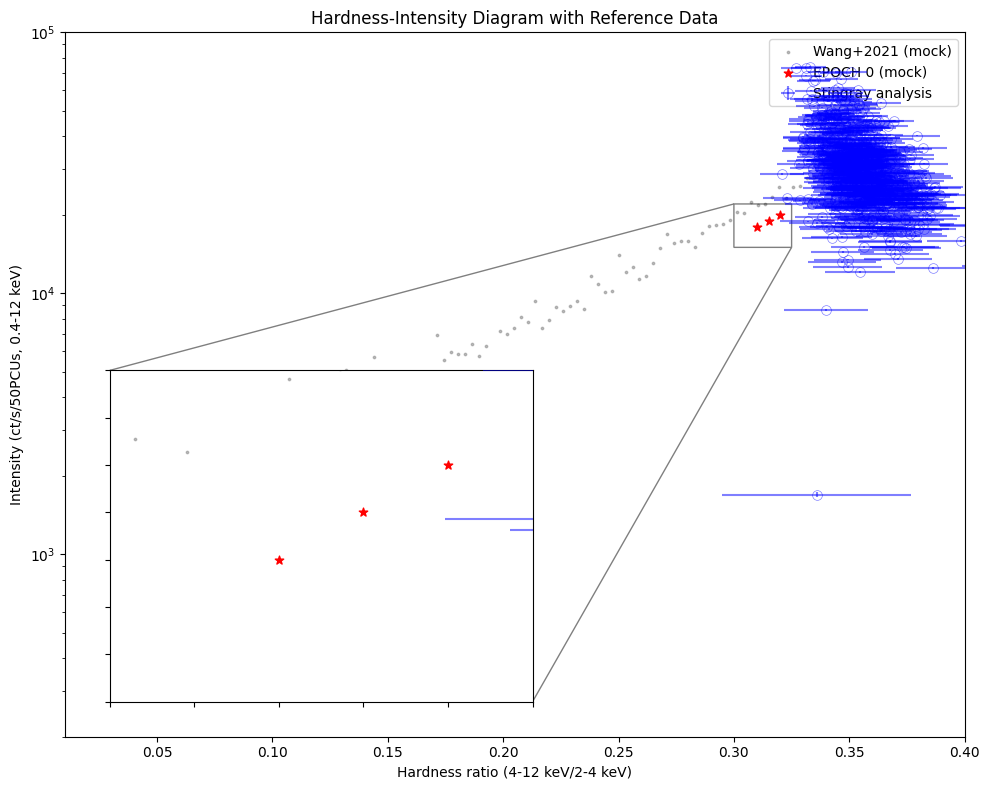

In [25]:
# Step 10: Compute & Plot Enhanced Hardness-Intensity Diagram (HID)

# Calculate number of detectors used (if available in your data)
# For NICER data, this information might be in the FITS header or events
try:
    # If det_id is available in your event data
    if 'DET_ID' in event_data.columns.names:
        ndet = len(set(event_data['DET_ID']))
    else:
        # Default value if detector information is not available
        ndet = 52  # Common NICER detector count
    print(f"NICER was using {ndet} detectors")
except:
    ndet = 52
    print(f"Assuming {ndet} detectors")

# Create energy bands for hardness ratio
soft_band = (energy_kev >= 2.0) & (energy_kev < 4.0)
hard_band = (energy_kev >= 4.0) & (energy_kev <= 12.0)
full_band = (energy_kev >= 0.4) & (energy_kev <= 12.0)

# Create light curves with the same time bins for all bands
dt = 10.0  # Larger time bin for better statistics
tstart = times.min()
tstop = times.max()

soft_event_list = EventList(time=times[soft_band])
hard_event_list = EventList(time=times[hard_band])
full_event_list = EventList(time=times[full_band])

soft_lc = soft_event_list.to_lc(dt=dt, tstart=tstart, tseg=tstop-tstart)
hard_lc = hard_event_list.to_lc(dt=dt, tstart=tstart, tseg=tstop-tstart)
full_lc = full_event_list.to_lc(dt=dt, tstart=tstart, tseg=tstop-tstart)

# Calculate hardness ratio and intensity
with np.errstate(divide='ignore', invalid='ignore'):
    hardness = np.where(soft_lc.counts > 0, hard_lc.counts / soft_lc.counts, np.nan)
    intensity = full_lc.counts  # Total intensity in the full band

# Calculate errors (Poisson statistics)
hardness_err = hardness * np.sqrt((np.sqrt(hard_lc.counts)/hard_lc.counts)**2 + 
                                 (np.sqrt(soft_lc.counts)/soft_lc.counts)**2)
intensity_err = np.sqrt(intensity)

# Remove NaN values
valid_mask = ~np.isnan(hardness) & ~np.isnan(hardness_err) & (hardness > 0)
hardness = hardness[valid_mask]
hardness_err = hardness_err[valid_mask]
intensity = intensity[valid_mask]
intensity_err = intensity_err[valid_mask]

# Mock comparison data (replace with your actual data)
# In your case, you would read this from files:
# wang_data = Table.read("wang_data.csv", names=["H", "I"])
# epoch0_wang_data = Table.read("epoch_0_data.csv", names=["H", "I"])

# Mock data for demonstration - replace with your actual data
wang_data_h = np.linspace(0.05, 0.35, 100)
wang_data_i = 1000 * np.exp(wang_data_h * 10) + np.random.normal(0, 1000, 100)
epoch_zero_h = np.array([0.31, 0.315, 0.32])
epoch_zero_i = np.array([18000, 19000, 20000])

# Create the enhanced HID plot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot our data points with error bars
plotline = ax.errorbar(
    hardness,
    intensity / ndet * 50,  # Normalize by detector count and scale
    yerr=intensity_err / ndet * 50,
    xerr=hardness_err,
    fmt='o',
    color='b',
    alpha=0.5,
    markersize=7,
    label='Stingray analysis',
    zorder=10
)
plotline[0].set_markerfacecolor('none')
plotline[0].set_markeredgewidth(0.5)

# Plot comparison data
ax.scatter(
    wang_data_h,
    wang_data_i / 52 * 50,  # Normalize by their detector count and scale
    alpha=0.5,
    color='grey',
    zorder=1,
    s=3,
    label='Wang+2021 (mock)'
)

# Set axis limits and labels
ax.set_xlim([0.01, 0.4])
ax.set_ylim([2e2, 1e5])
ax.set_xlabel('Hardness ratio (4-12 keV/2-4 keV)')
ax.set_ylabel('Intensity (ct/s/50PCUs, 0.4-12 keV)')
ax.set_yscale('log')

# Add special epoch data points
ax.scatter(
    epoch_zero_h, 
    epoch_zero_i, 
    marker='*', 
    color='red', 
    zorder=2, 
    s=40, 
    label='EPOCH 0 (mock)'
)

# Create zoomed inset
axins = ax.inset_axes(
    [0.05, 0.05, 0.47, 0.47], 
    xlim=(0.30, 0.325), 
    ylim=(1.5e4, 2.2e4), 
    xticklabels=[], 
    yticklabels=[]
)

# Add data to the inset
axins.scatter(wang_data_h, wang_data_i / 52 * 50, alpha=0.5, color='grey', zorder=1, s=3)
axins.errorbar(
    hardness,
    intensity / ndet * 50,
    yerr=intensity_err / ndet * 50,
    xerr=hardness_err,
    fmt='o',
    color='b',
    alpha=0.5,
    markersize=7,
    zorder=10
)
axins.scatter(epoch_zero_h, epoch_zero_i, marker='*', color='red', zorder=2, s=40)

# Add zoom indicator
ax.indicate_inset_zoom(axins, edgecolor='black')

# Add legend
ax.legend(loc='upper right')

plt.title('Hardness-Intensity Diagram with Reference Data')
plt.tight_layout()
plt.show()